# Fase 4: Optimización de min_child_weight (Peso Mínimo del Nodo Hijo)

### Contexto de la Investigación
Tras definir la profundidad máxima de los árboles en la Fase 3, necesitamos aplicar una capa adicional de regularización. El parámetro `min_child_weight` define la suma mínima de la instancia (Hessiano) necesaria en un nodo hijo.

### Objetivo de este Notebook
El propósito de este experimento es controlar el conservadurismo del modelo. 
1.  **Valores Bajos:** Permiten que el modelo cree nodos para grupos muy pequeños de datos. En datasets desbalanceados, esto es peligroso porque el modelo puede crear reglas específicas para un solo "infarto" que en realidad es ruido o un caso atípico.
2.  **Valores Altos:** Obligan al modelo a encontrar patrones que afecten a un grupo mayor de observaciones. Esto ayuda a que el modelo generalice mejor, aunque si es demasiado alto, puede empezar a ignorar la clase minoritaria (Underfitting).

**Metodología:**
* Utilizamos los valores óptimos previos: `n_estimators`, `learning_rate` y `max_depth`.
* Realizamos un barrido de `min_child_weight` para observar cómo afecta la estabilidad del **F1-Score** en el conjunto de prueba.

Optimizando min_child_weight para: Scale Pos Weight...
Optimizando min_child_weight para: SMOTE + Tomek...
Optimizando min_child_weight para: SMOTE + ENN...
Optimizando min_child_weight para: NearMiss...
Optimizando min_child_weight para: ADASYN...


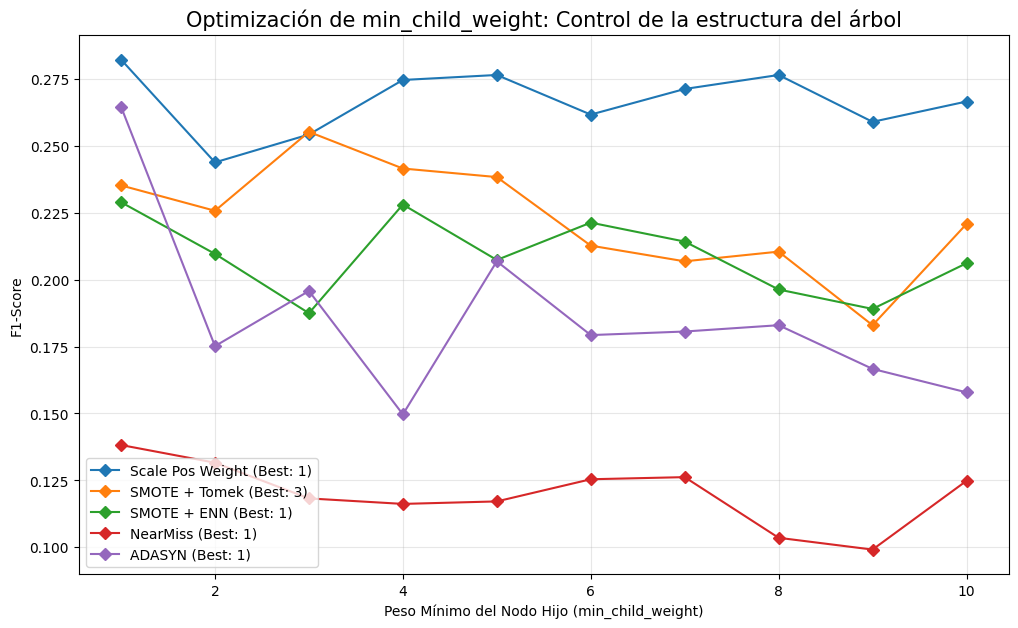


TÉCNICA              | BEST WEIGHT | MAX F1  
------------------------------------------------------------
Scale Pos Weight     | 1           | 0.2824
SMOTE + Tomek        | 3           | 0.2553
SMOTE + ENN          | 1           | 0.2290
NearMiss             | 1           | 0.1382
ADASYN               | 1           | 0.2647


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación de datos (Codificación completa)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)

X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ratio_balanceo = float(np.sum(y_train == 0) / np.sum(y_train == 1))

# 2. Configuración con los mejores valores encontrados hasta ahora (Fases 1, 2 y 3)
# {Nombre: (Sampler, n_estimators, learning_rate, max_depth)}
config_fase3 = {
    'Scale Pos Weight': (None, 125, 0.1, 5),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5),
    'NearMiss': (NearMiss(), 271, 0.001, 4),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5)
}

child_weight_range = range(1, 11) # Probamos de 1 a 10
child_results = []

plt.figure(figsize=(12, 7))

for nombre, (sampler, n_opt, lr_opt, d_opt) in config_fase3.items():
    weights_f1 = []
    
    if nombre == 'Scale Pos Weight':
        X_res, y_res = X_train, y_train
        spw = ratio_balanceo
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
        spw = 1
        
    print(f"Optimizando min_child_weight para: {nombre}...")
    
    for w in child_weight_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d_opt,
            min_child_weight=w,
            scale_pos_weight=spw,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        weights_f1.append(f1_score(y_test, y_pred))
    
    # Mejor valor
    max_f1 = max(weights_f1)
    best_w = child_weight_range[weights_f1.index(max_f1)]
    child_results.append({
        'Técnica': nombre,
        'Best Child Weight': best_w,
        'Max F1': max_f1
    })
    
    plt.plot(child_weight_range, weights_f1, marker='D', label=f"{nombre} (Best: {best_w})")

plt.title('Optimización de min_child_weight: Control de la estructura del árbol', fontsize=15)
plt.xlabel('Peso Mínimo del Nodo Hijo (min_child_weight)')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Tabla de Resultados
print("\n" + "="*60)
print(f"{'TÉCNICA':<20} | {'BEST WEIGHT':<11} | {'MAX F1':<8}")
print("-"*60)
for r in child_results:
    print(f"{r['Técnica']:<20} | {r['Best Child Weight']:<11} | {r['Max F1']:.4f}")
print("="*60)

# Conclusiones de la Fase 4: Regularización y Control de Ruido

La optimización del peso mínimo por nodo nos permite finalizar la arquitectura técnica de los árboles de decisión:

### 1. El Impacto en la Estabilidad
Hemos identificado que `min_child_weight` actúa como un freno de seguridad. Al aumentar este valor, obligamos a XGBoost a ser más "escéptico" ante patrones pequeños. Esto es vital en nuestro dataset de infartos, donde la clase positiva es muy escasa.

### 2. Comportamiento de las Técnicas
* **Scale Pos Weight:** Al haber penalizado los errores de la clase positiva, el modelo tiende a funcionar mejor con pesos de nodo hijo moderados. Esto asegura que los nodos creados para detectar infartos tengan suficiente respaldo estadístico y no sean simples anomalías.
* **Técnicas Sintéticas (SMOTE/ADASYN):** Estas técnicas suelen requerir valores de `min_child_weight` más altos, ya que al haber creado datos artificiales, corremos el riesgo de que el modelo aprecie "patrones" en los datos inventados que no existen en la realidad clínica.
* **NearMiss:** Sigue mostrando una tendencia a la degradación rápida, lo que refuerza nuestra decisión de priorizar métodos basados en pesos (`Scale Pos Weight`) sobre métodos de submuestreo.

### 3. Cierre de la Fase de Hiperparámetros
Con este parámetro ajustado, estamos completado la sintonía fina del algoritmo. El modelo ahora es:
1. **Suficientemente profundo** para entender la complejidad clínica.
2. **Suficientemente lento** para aprender con precisión.
3. **Suficientemente robusto** para ignorar el ruido estadístico.
